## Data generator

The size of dataset is large (27 Gb of memory). So to load whole dataset into memory to start training deep learning model we need really powerfull machine. But instead we can apply other approaches and one of them is using data generators.  
  
Generator allow you to declare a function that behaves like an iterator, i.e. it can be used in a for loop. So we can set up such kind of function that can return batches of certain size from dataset step-by-step.  

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models as sm

from tensorflow.keras.preprocessing.image import ImageDataGenerator

CSV_SHIP_LABELS_TRAIN_PATH = '../data/train_ship_segmentations_v2.csv/train_filtered_ships.csv'
TRAIN_PICS_DIRECTORY = '../data/train_v2/'

Segmentation Models: using `tf.keras` framework.


Implement function to conver labels from `start & run` format to `2D masks`

In [3]:
def mask_converter(values):
    mask = np.zeros((768*768,), dtype=float)        #create empty one-dimentional vector with zeros
    if values != "none":
        values = values.strip().split()
        start_points = values[0::2]               #separate values
        lengths = values[1::2]
        for st_p, l in zip(start_points, lengths):     #fill mask with ones according to the EncodedPixels colomn
            st_p, l = int(st_p)-1, int(l)
            ones = np.ones(l, dtype=int) 
            mask[int(st_p):int(st_p)+int(l)] = ones
    return np.transpose(mask.reshape((768, 768, 1)), axes=(1, 0, 2))    #rotate image to get correct orientation

Preprocess .csv file before training. Usage of empty images is optional

In [4]:
def get_masks(csv_data_file, use_empty_images):
    labels = pd.read_csv(csv_data_file)
    if not use_empty_images:
        labels['EncodedPixels'].replace(to_replace=np.nan, value="none", inplace=True)
        labels = labels[labels['EncodedPixels'] != 'none']    
    grouped_labels = labels.groupby('ImageId', as_index=False)['EncodedPixels'].apply(' '.join)
    return grouped_labels

We have a Dataframe with all file names of images from dataset. On each iteration we get certain amount of filenames and corresponding labels. Then we can read those images from disk and convert labels to 2D masks. In the end we return (yield) arrays of images and masks

In [12]:
def data_generator(csv_data_file, image_folder_path, batch_size, epochs, use_empty_images=False, augmentation=False, aug_cycles=3, aug_batch_size=32):              
    """
    Yields the next data batch.
    """
    labels = get_masks(csv_data_file, use_empty_images)
    num_images = len(labels)
    for _ in range(epochs):
        for offset in range(0, num_images, batch_size):        
            # Get the samples you'll use in this batch
            batch_images = labels['ImageId'][offset:offset+batch_size].values
            batch_masks = labels['EncodedPixels'][offset:offset+batch_size].values
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for image_filename, mask_encoded in zip(batch_images, batch_masks):          
                # Add example to arrays
                image = cv2.imread(f"{image_folder_path}/{image_filename}")
                mask = mask_converter(mask_encoded)
                image = cv2.resize(image, (256, 256), interpolation=None)
                mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
                X_train.append(image)
                y_train.append(mask)

            X_train = np.array(X_train)/255
            y_train = np.array(y_train)[..., np.newaxis]

            if augmentation:
                image_gen = ImageDataGenerator(horizontal_flip=True,
                                               vertical_flip=True,
                                               width_shift_range=0.2,
                                               height_shift_range=0.2
                                                          )
                mask_gen = ImageDataGenerator(horizontal_flip=True,
                                              vertical_flip=True,
                                              width_shift_range=0.2,
                                              height_shift_range=0.2
                                                          )
                image_gen.fit(X_train)
                mask_gen.fit(y_train)
                counter = 0
                for X_aug_train, y_aug_train in zip(image_gen.flow(X_train, batch_size=aug_batch_size, seed=42), mask_gen.flow(y_train, batch_size=aug_batch_size, seed=42)):
                    if counter == aug_cycles:
                        counter = 0
                        break
                    counter += 1
                    yield (X_aug_train, y_aug_train)
            else:
                yield (X_train, y_train)
                # yield the next training batch

Now we can crete instance of data_generator

In [13]:
train_generator = data_generator(csv_data_file=CSV_SHIP_LABELS_TRAIN_PATH, image_folder_path=TRAIN_PICS_DIRECTORY, batch_size=32, epochs=1)
X_batch, y_batch = next(train_generator)

The structure of shape tuple is (batch_size, height, width, color_channels)

In [14]:
print(f"X shape - {X_batch.shape}")
print(f"y shape - {y_batch.shape}")

X shape - (32, 256, 256, 3)
y shape - (32, 256, 256, 1)


Now we can plot some images from the batch with masks over them to make sure it works correctly

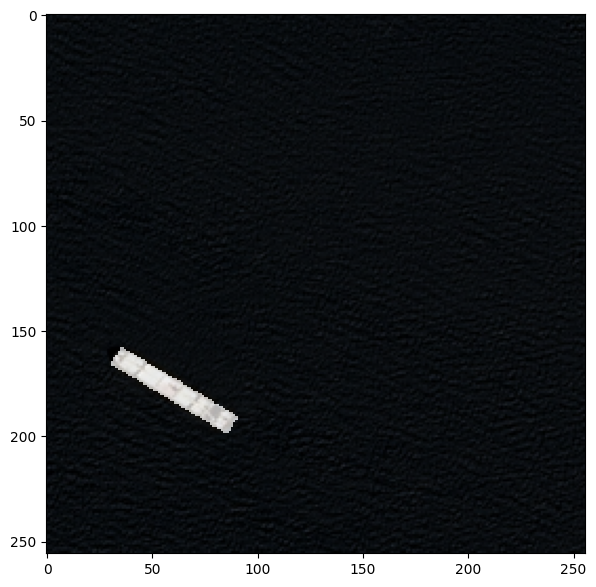

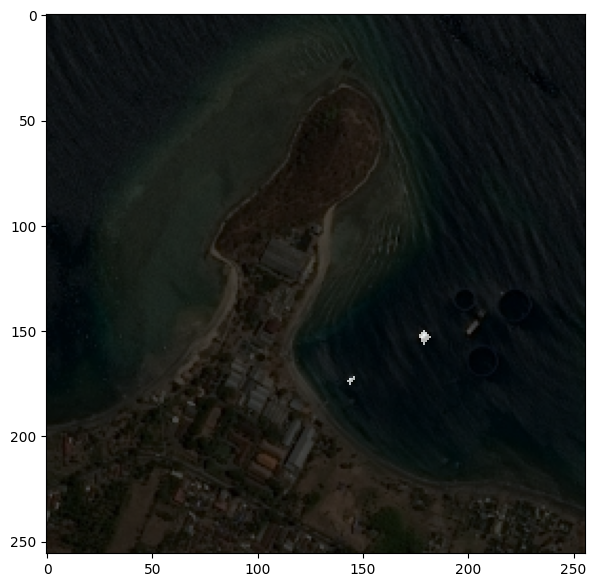

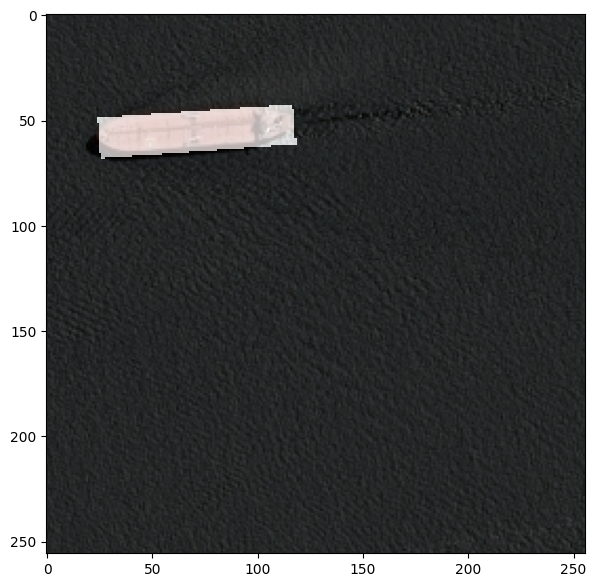

In [15]:
for indx in range(15, 18):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(X_batch[indx].astype('float32'), cv2.COLOR_BGR2RGB))
    plt.imshow(y_batch[indx], 'gray', interpolation='none', alpha=0.7)

Or we can even use Data Augmentation technics with flips and shifts of images and corresponding masks

In [16]:
train_augmented_generator = data_generator(csv_data_file=CSV_SHIP_LABELS_TRAIN_PATH, image_folder_path=TRAIN_PICS_DIRECTORY, batch_size=32, epochs=1, augmentation=True)
X_aug_train, y_aug_train = next(train_augmented_generator)

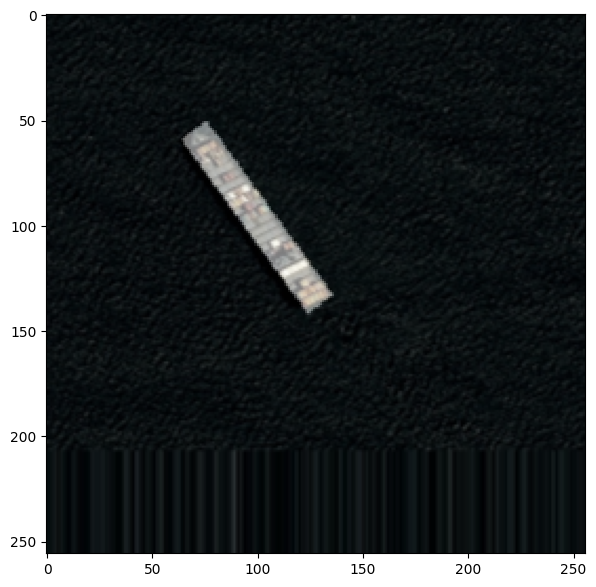

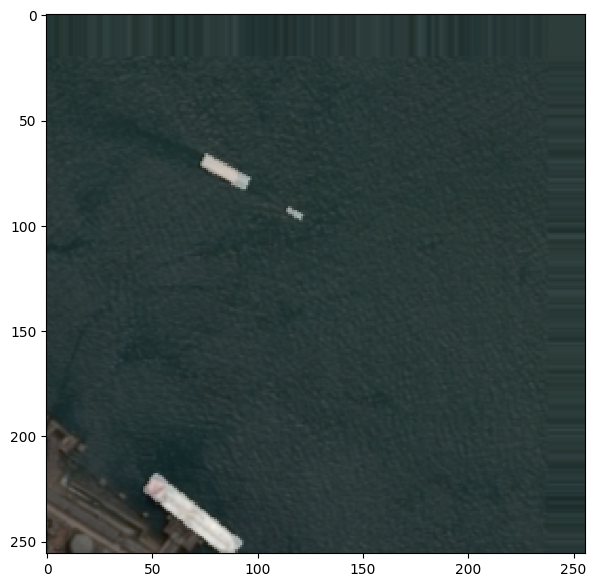

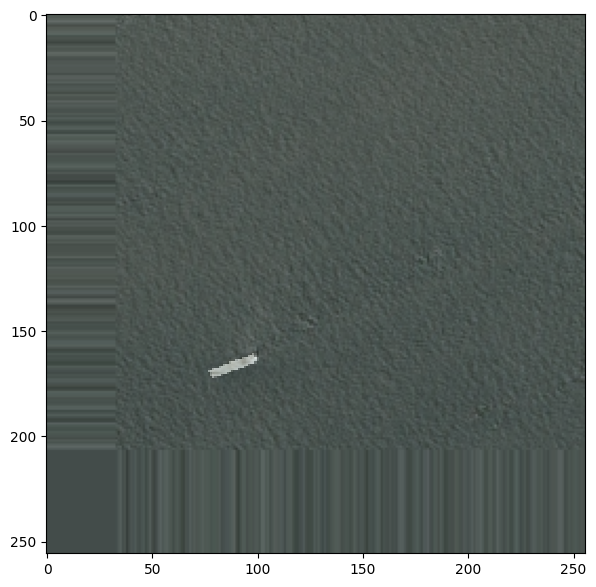

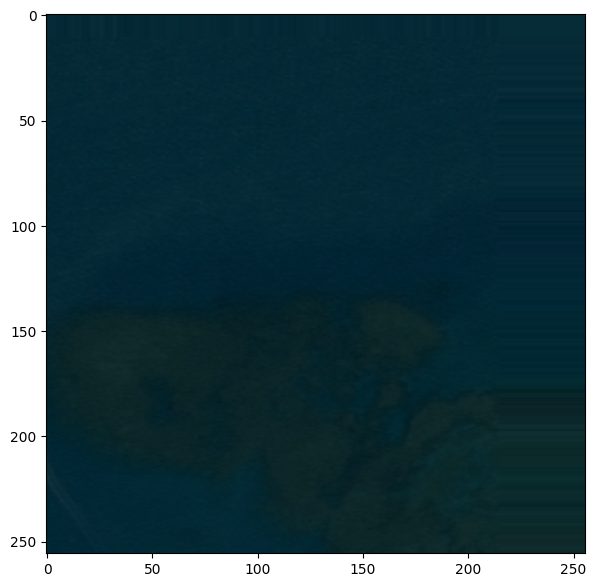

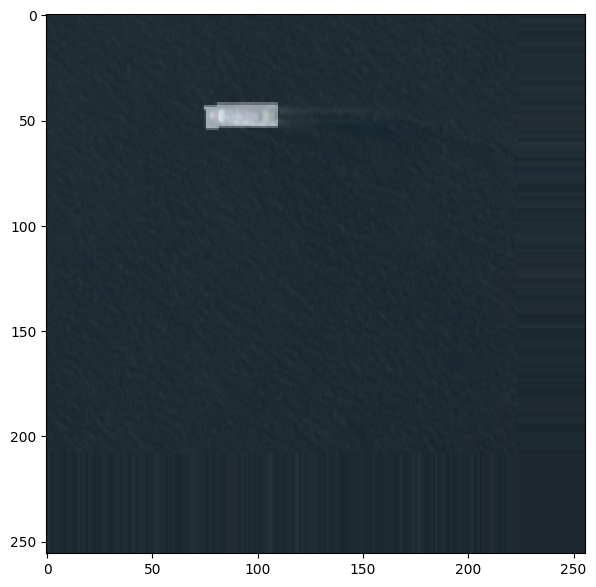

In [17]:
for indx in range(5, 10):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(X_aug_train[indx].astype('float32'), cv2.COLOR_BGR2RGB))
    plt.imshow(y_aug_train[indx], 'gray', interpolation='none', alpha=0.5)